In [1]:
import os
print(os.getcwd())  # this is where Jupyter is looking from
#one folder back
os.chdir('..')
print(os.getcwd())

/root/n1_masters_thesis/model_training
/root/n1_masters_thesis


In [2]:
import pandas as pd
import numpy as np
from load_data import load_dataset, ImageDataset

from split import get_dataloaders
from custom_data_aug import get_transforms
from auto_aug import get_autoaugment_transforms

import torch
import torch.nn as nn
import torchvision
from config import CFG

from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter
from training import train  # or wherever your updated function lives

from acc_loss_plot import plot_training_curves

In [3]:
# Load the dataframe
csv_path = "/root/n1_masters_thesis/filtered_df.csv"
image_dir = "/root/n1_masters_thesis/image_data/image_data"
df, idx_to_label = load_dataset(csv_path, image_dir)

In [4]:
print(df.head())

                                           file_name label  label_idx
0  /root/n1_masters_thesis/image_data/image_data/...    BC          0
1  /root/n1_masters_thesis/image_data/image_data/...    BC          0
2  /root/n1_masters_thesis/image_data/image_data/...    BC          0
3  /root/n1_masters_thesis/image_data/image_data/...    BC          0
4  /root/n1_masters_thesis/image_data/image_data/...    BC          0


In [5]:
train_transforms, val_transforms = get_transforms()

train_dataset, val_dataset, train_loader, val_loader = get_dataloaders(
    df, train_transforms, val_transforms
)

In [6]:
def build_model(device: torch.device, num_classes: int = CFG.NUM_CLASSES) -> nn.Module:
    # Set seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer3.parameters():
        param.requires_grad = True
    
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, num_classes)
    ).to(device)

    return model

In [7]:
cnn = build_model(device=CFG.DEVICE)

# View model summary
summary(
    model=cnn, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 34]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [8]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.Adam(
    cnn.parameters(),
    lr=CFG.LR
)

In [9]:
writer = SummaryWriter(log_dir="runs/exp1_efficientnet")

session = train(
    model=cnn,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=CFG.EPOCHS,
    device=CFG.DEVICE,
    writer=writer
)

writer.close()


Epoch 1/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 2.7190 - top1: 0.2430 - top5: 0.6168 - eval_loss: 1.8667 - eval_top1: 0.4926 - eval_top5: 0.9286

Epoch 2/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.9873 - top1: 0.4713 - top5: 0.8771 - eval_loss: 1.6136 - eval_top1: 0.6183 - eval_top5: 0.9566

Epoch 3/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.7881 - top1: 0.5496 - top5: 0.9088 - eval_loss: 1.4553 - eval_top1: 0.6820 - eval_top5: 0.9638

Epoch 4/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.6527 - top1: 0.6055 - top5: 0.9260 - eval_loss: 1.3994 - eval_top1: 0.6914 - eval_top5: 0.9688

Epoch 5/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.5886 - top1: 0.6452 - top5: 0.9295 - eval_loss: 1.4446 - eval_top1: 0.6767 - eval_top5: 0.9663

Epoch 6/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.5229 - top1: 0.6723 - top5: 0.9351 - eval_loss: 1.3644 - eval_top1: 0.7138 - eval_top5: 0.9724

Epoch 7/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.4815 - top1: 0.6787 - top5: 0.9442 - eval_loss: 1.3140 - eval_top1: 0.7467 - eval_top5: 0.9639

Epoch 8/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.4519 - top1: 0.6995 - top5: 0.9445 - eval_loss: 1.2981 - eval_top1: 0.7541 - eval_top5: 0.9639

Epoch 9/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.4158 - top1: 0.7094 - top5: 0.9514 - eval_loss: 1.3032 - eval_top1: 0.7368 - eval_top5: 0.9675

Epoch 10/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3964 - top1: 0.7169 - top5: 0.9525 - eval_loss: 1.2617 - eval_top1: 0.7550 - eval_top5: 0.9748

Epoch 11/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3643 - top1: 0.7322 - top5: 0.9533 - eval_loss: 1.2766 - eval_top1: 0.7495 - eval_top5: 0.9772

Epoch 12/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3491 - top1: 0.7385 - top5: 0.9551 - eval_loss: 1.2680 - eval_top1: 0.7447 - eval_top5: 0.9736

Epoch 13/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3229 - top1: 0.7460 - top5: 0.9614 - eval_loss: 1.2554 - eval_top1: 0.7515 - eval_top5: 0.9760

Epoch 14/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3274 - top1: 0.7460 - top5: 0.9570 - eval_loss: 1.2515 - eval_top1: 0.7572 - eval_top5: 0.9808

Epoch 15/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3116 - top1: 0.7563 - top5: 0.9596 - eval_loss: 1.2091 - eval_top1: 0.7780 - eval_top5: 0.9832

Epoch 16/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2793 - top1: 0.7645 - top5: 0.9639 - eval_loss: 1.2267 - eval_top1: 0.7624 - eval_top5: 0.9784

Epoch 17/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2895 - top1: 0.7588 - top5: 0.9598 - eval_loss: 1.2496 - eval_top1: 0.7567 - eval_top5: 0.9796

Epoch 18/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2592 - top1: 0.7763 - top5: 0.9637 - eval_loss: 1.1758 - eval_top1: 0.7938 - eval_top5: 0.9820

Epoch 19/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2568 - top1: 0.7765 - top5: 0.9637 - eval_loss: 1.1851 - eval_top1: 0.8000 - eval_top5: 0.9844

Epoch 20/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2358 - top1: 0.7820 - top5: 0.9679 - eval_loss: 1.2078 - eval_top1: 0.7687 - eval_top5: 0.9820

Epoch 21/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2347 - top1: 0.7822 - top5: 0.9677 - eval_loss: 1.1845 - eval_top1: 0.8001 - eval_top5: 0.9808

Epoch 22/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2192 - top1: 0.7942 - top5: 0.9714 - eval_loss: 1.2113 - eval_top1: 0.8010 - eval_top5: 0.9808

Epoch 23/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2086 - top1: 0.7952 - top5: 0.9684 - eval_loss: 1.2281 - eval_top1: 0.7795 - eval_top5: 0.9784

Epoch 24/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2003 - top1: 0.7959 - top5: 0.9697 - eval_loss: 1.1578 - eval_top1: 0.8073 - eval_top5: 0.9784

Epoch 25/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1854 - top1: 0.8047 - top5: 0.9707 - eval_loss: 1.2258 - eval_top1: 0.7763 - eval_top5: 0.9760

Epoch 26/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1736 - top1: 0.8109 - top5: 0.9722 - eval_loss: 1.1641 - eval_top1: 0.8128 - eval_top5: 0.9808

Epoch 27/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1702 - top1: 0.8070 - top5: 0.9716 - eval_loss: 1.1904 - eval_top1: 0.7977 - eval_top5: 0.9796

Epoch 28/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1586 - top1: 0.8142 - top5: 0.9736 - eval_loss: 1.1554 - eval_top1: 0.8139 - eval_top5: 0.9784

Epoch 29/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1648 - top1: 0.8134 - top5: 0.9730 - eval_loss: 1.1910 - eval_top1: 0.8142 - eval_top5: 0.9820

Epoch 30/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1583 - top1: 0.8162 - top5: 0.9745 - eval_loss: 1.1872 - eval_top1: 0.7926 - eval_top5: 0.9868

Epoch 31/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1467 - top1: 0.8193 - top5: 0.9758 - eval_loss: 1.2510 - eval_top1: 0.7576 - eval_top5: 0.9760

Epoch 32/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1576 - top1: 0.8191 - top5: 0.9734 - eval_loss: 1.1740 - eval_top1: 0.7995 - eval_top5: 0.9868

Epoch 33/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1235 - top1: 0.8319 - top5: 0.9761 - eval_loss: 1.1600 - eval_top1: 0.7988 - eval_top5: 0.9832

Epoch 34/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1192 - top1: 0.8294 - top5: 0.9777 - eval_loss: 1.2021 - eval_top1: 0.7904 - eval_top5: 0.9772

Epoch 35/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1173 - top1: 0.8401 - top5: 0.9773 - eval_loss: 1.1606 - eval_top1: 0.7950 - eval_top5: 0.9760

Epoch 36/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1199 - top1: 0.8348 - top5: 0.9748 - eval_loss: 1.1879 - eval_top1: 0.8022 - eval_top5: 0.9796

Epoch 37/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0988 - top1: 0.8407 - top5: 0.9767 - eval_loss: 1.1811 - eval_top1: 0.7989 - eval_top5: 0.9784

Epoch 38/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1022 - top1: 0.8434 - top5: 0.9771 - eval_loss: 1.1585 - eval_top1: 0.8166 - eval_top5: 0.9844

Epoch 39/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1034 - top1: 0.8391 - top5: 0.9771 - eval_loss: 1.2052 - eval_top1: 0.7890 - eval_top5: 0.9760

Epoch 40/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0895 - top1: 0.8466 - top5: 0.9783 - eval_loss: 1.2167 - eval_top1: 0.7855 - eval_top5: 0.9772

Epoch 41/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0886 - top1: 0.8437 - top5: 0.9775 - eval_loss: 1.2099 - eval_top1: 0.7867 - eval_top5: 0.9760

Epoch 42/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0847 - top1: 0.8487 - top5: 0.9781 - eval_loss: 1.1747 - eval_top1: 0.8060 - eval_top5: 0.9808

Epoch 43/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0780 - top1: 0.8500 - top5: 0.9774 - eval_loss: 1.1454 - eval_top1: 0.8120 - eval_top5: 0.9808

Epoch 44/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0638 - top1: 0.8578 - top5: 0.9817 - eval_loss: 1.1864 - eval_top1: 0.8036 - eval_top5: 0.9796

Epoch 45/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0586 - top1: 0.8606 - top5: 0.9795 - eval_loss: 1.1946 - eval_top1: 0.8108 - eval_top5: 0.9772

Epoch 46/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0610 - top1: 0.8578 - top5: 0.9804 - eval_loss: 1.1890 - eval_top1: 0.8104 - eval_top5: 0.9700

Epoch 47/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0638 - top1: 0.8612 - top5: 0.9791 - eval_loss: 1.2325 - eval_top1: 0.7905 - eval_top5: 0.9748

Epoch 48/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0529 - top1: 0.8603 - top5: 0.9815 - eval_loss: 1.1565 - eval_top1: 0.8228 - eval_top5: 0.9748

Epoch 49/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0466 - top1: 0.8636 - top5: 0.9808 - eval_loss: 1.1865 - eval_top1: 0.8106 - eval_top5: 0.9712

Epoch 50/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0405 - top1: 0.8643 - top5: 0.9820 - eval_loss: 1.1958 - eval_top1: 0.8012 - eval_top5: 0.9736

Epoch 51/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0286 - top1: 0.8709 - top5: 0.9822 - eval_loss: 1.2037 - eval_top1: 0.8073 - eval_top5: 0.9760

Epoch 52/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0378 - top1: 0.8662 - top5: 0.9802 - eval_loss: 1.1983 - eval_top1: 0.8072 - eval_top5: 0.9748

Epoch 53/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0373 - top1: 0.8663 - top5: 0.9803 - eval_loss: 1.2084 - eval_top1: 0.7984 - eval_top5: 0.9748

Epoch 54/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0296 - top1: 0.8658 - top5: 0.9824 - eval_loss: 1.1916 - eval_top1: 0.7996 - eval_top5: 0.9760

Epoch 55/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0269 - top1: 0.8713 - top5: 0.9808 - eval_loss: 1.1898 - eval_top1: 0.8170 - eval_top5: 0.9700

Epoch 56/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0265 - top1: 0.8773 - top5: 0.9829 - eval_loss: 1.2047 - eval_top1: 0.7976 - eval_top5: 0.9748

Epoch 57/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0277 - top1: 0.8671 - top5: 0.9819 - eval_loss: 1.1735 - eval_top1: 0.8012 - eval_top5: 0.9796

Epoch 58/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0042 - top1: 0.8808 - top5: 0.9861 - eval_loss: 1.1949 - eval_top1: 0.8108 - eval_top5: 0.9796

Epoch 59/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0119 - top1: 0.8788 - top5: 0.9809 - eval_loss: 1.2034 - eval_top1: 0.7902 - eval_top5: 0.9808

Epoch 60/60


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.0055 - top1: 0.8802 - top5: 0.9848 - eval_loss: 1.2203 - eval_top1: 0.8032 - eval_top5: 0.9772


In [12]:
# Convert history dict to DataFrame
session_history_df = pd.DataFrame(session)
session_history_df

,loss,accuracy,top5_accuracy,eval_loss,eval_accuracy,eval_top5_accuracy
0,2.718967,0.243045,0.616800,1.866658,0.492617,0.928571
1,1.987321,0.471337,0.877140,1.613596,0.618304,0.956559
2,1.788146,0.549586,0.908792,1.455333,0.682005,0.963771
3,1.652723,0.605514,0.925959,1.399399,0.691449,0.968750
4,1.588551,0.645182,0.929453,1.444626,0.676683,0.966346
5,1.522877,0.672325,0.935073,1.364403,0.713771,0.972356
6,1.481542,0.678706,0.944206,1.313999,0.746738,0.963942
7,1.451881,0.699545,0.944468,1.298110,0.754121,0.963942
8,1.415822,0.709406,0.951378,1.303165,0.736779,0.967548
9,1.396364,0.716904,0.952451,1.261709,0.754979,0.974760


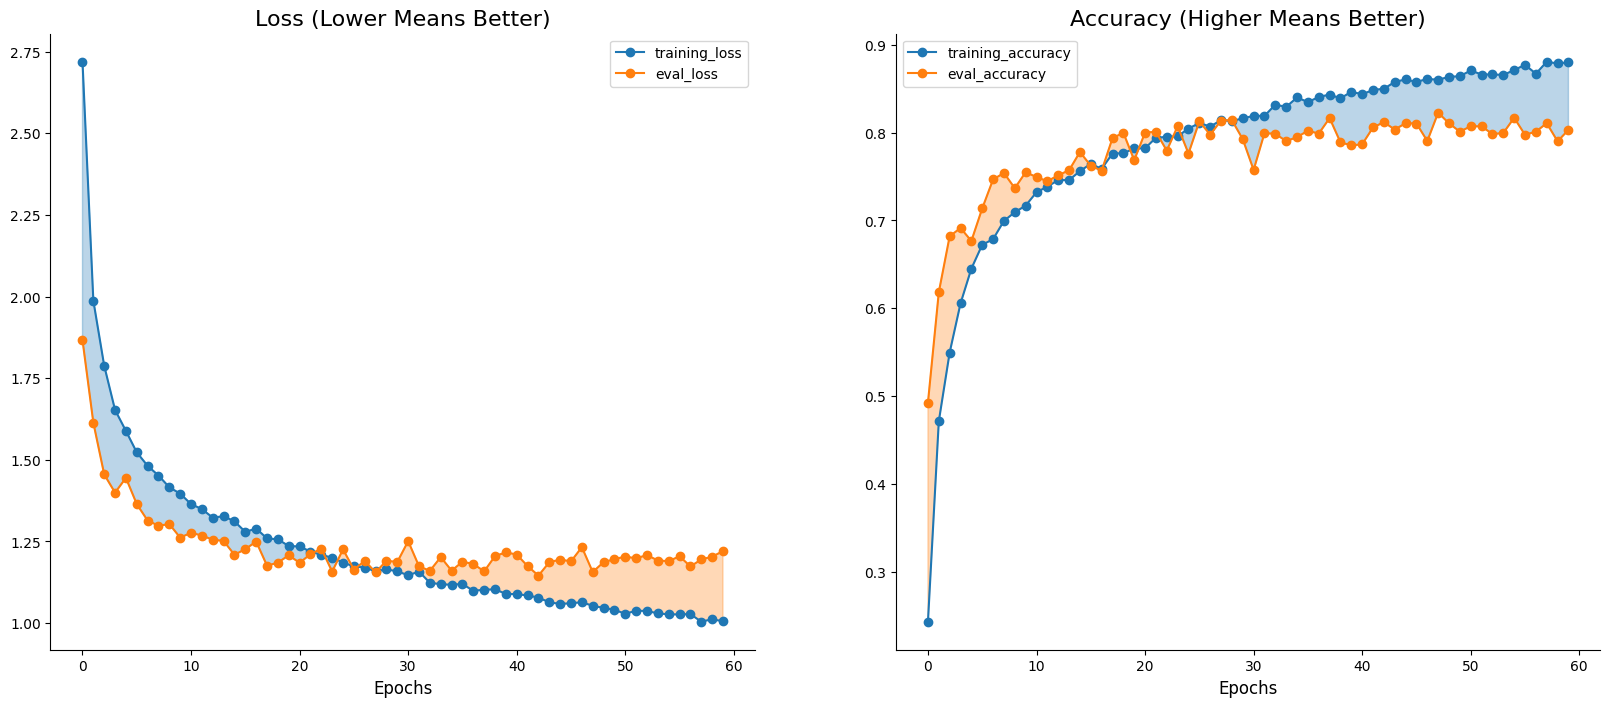

In [13]:
from acc_loss_plot import plot_training_curves
# Plot EfficientNet session training history 
plot_training_curves(session)